### Stock Market Prediction And Forecasting Using Stacked LSTM

In [2]:
### Data Collection
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

key="0865c38d3aedbee689ebe90b827d19cdf38ef940"

In [34]:
df = pdr.get_data_tiingo('AAPL', api_key=key, start='2001-01-01', end='2023-06-01')

In [35]:
df.to_csv('AAPL.csv')

In [36]:
df=pd.read_csv('AAPL.csv')

In [37]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2001-01-02 00:00:00+00:00,14.88,15.25,14.56,14.88,8077000,0.225813,0.231428,0.220957,0.225813,452312452,0.0,1.0
1,AAPL,2001-01-03 00:00:00+00:00,16.37,16.69,14.44,14.50,14590600,0.248425,0.253281,0.219136,0.220047,817074417,0.0,1.0
2,AAPL,2001-01-04 00:00:00+00:00,17.06,18.50,16.81,18.14,13203500,0.258896,0.280749,0.255102,0.275286,739396739,0.0,1.0
3,AAPL,2001-01-05 00:00:00+00:00,16.37,17.37,16.06,16.94,7363500,0.248425,0.263601,0.243721,0.257075,412356412,0.0,1.0
4,AAPL,2001-01-08 00:00:00+00:00,16.56,16.98,15.94,16.94,6673200,0.251309,0.257682,0.241900,0.257075,373699573,0.0,1.0


In [38]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
5634,AAPL,2023-05-25 00:00:00+00:00,172.99,173.895,171.6900,172.410,56058258,172.99,173.895,171.6900,172.410,56058258,0.0,1.0
5635,AAPL,2023-05-26 00:00:00+00:00,175.43,175.770,173.1100,173.320,54834975,175.43,175.770,173.1100,173.320,54834975,0.0,1.0
5636,AAPL,2023-05-30 00:00:00+00:00,177.30,178.990,176.5700,176.960,55964401,177.30,178.990,176.5700,176.960,55964401,0.0,1.0
5637,AAPL,2023-05-31 00:00:00+00:00,177.25,179.350,176.7600,177.325,99313268,177.25,179.350,176.7600,177.325,99313268,0.0,1.0
5638,AAPL,2023-06-01 00:00:00+00:00,180.09,180.120,176.9306,177.700,68901809,180.09,180.120,176.9306,177.700,68901809,0.0,1.0


In [39]:
df1=df.reset_index()['close']

In [40]:
df1

0        14.88
1        16.37
2        17.06
3        16.37
4        16.56
         ...  
5634    172.99
5635    175.43
5636    177.30
5637    177.25
5638    180.09
Name: close, Length: 5639, dtype: float64

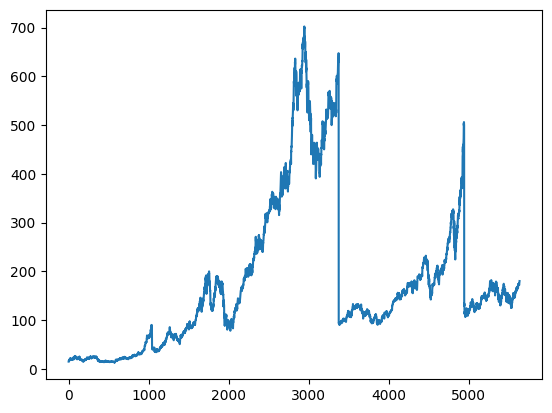

In [41]:
plt.plot(df1)

In [42]:
df1

0        14.88
1        16.37
2        17.06
3        16.37
4        16.56
         ...  
5634    172.99
5635    175.43
5636    177.30
5637    177.25
5638    180.09
Name: close, Length: 5639, dtype: float64

In [43]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [44]:
print(df1)

[[0.0025545 ]
 [0.00471712]
 [0.0057186 ]
 ...
 [0.23829429]
 [0.23822172]
 [0.24234375]]


In [51]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [52]:
training_size,test_size

(3665, 1974)

In [53]:
train_data

array([[0.0025545 ],
       [0.00471712],
       [0.0057186 ],
       ...,
       [0.15914831],
       [0.16003367],
       [0.15946762]])

In [81]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [85]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 600
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [86]:
print(X_train.shape), print(y_train.shape)

(3064, 600)
(3064,)


(None, None)

In [87]:
print(X_test.shape), print(ytest.shape)

(1373, 600)
(1373,)


(None, None)

In [88]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [89]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [94]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(600,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


In [95]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 600, 50)           10400     
                                                                 
 lstm_22 (LSTM)              (None, 600, 50)           20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [96]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=20,batch_size=64,verbose=1)

Epoch 1/20
48/48 [==============================] - 65s 1s/step - loss: 0.0168 - val_loss: 0.0021
Epoch 2/20
48/48 [==============================] - 58s 1s/step - loss: 0.0022 - val_loss: 0.0022
Epoch 3/20
48/48 [==============================] - 49s 1s/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/20
48/48 [==============================] - 36s 747ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 5/20
48/48 [==============================] - 37s 781ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 6/20
48/48 [==============================] - 38s 784ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/20
48/48 [==============================] - 38s 803ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/20
48/48 [==============================] - 37s 779ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 9/20
48/48 [==============================] - 38s 785ms/step - loss: 0.0011 - val_loss: 9.6604e-04
Epoch 10/20
48/48 [==============================] - 40s 834ms/step - loss: 0.0011 - val_loss: 9

In [97]:
import tensorflow as tf

In [26]:
tf.__version__

'2.12.0'

In [98]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

43/43 [==============================] - 6s 144ms/step


In [99]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


0.023032421650940587

In [100]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.023304380500530523

In [101]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

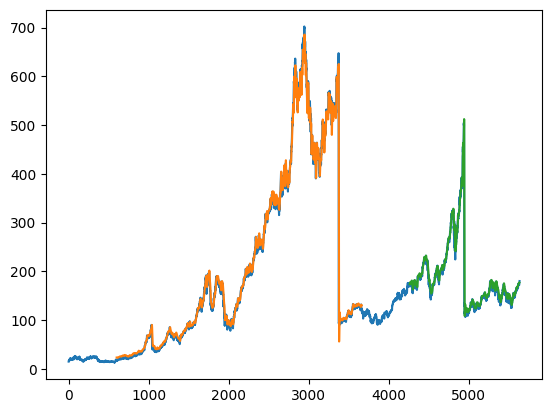

In [104]:
### Plotting 
# shift train predictions for plotting
look_back=600
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [105]:
len(test_data)

1974

In [107]:
x_input=test_data[1374:].reshape(1,-1)
x_input.shape


(1, 600)

In [108]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [113]:
temp_input

600

In [125]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=600
i=0
while(i<10):
    
    if(len(temp_input)>599):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    
len(lst_output)

0 day input [0.17248686 0.17565096 0.17688467 0.17536068 0.18036808 0.17945369
 0.1796714  0.17836512 0.17746524 0.17708787 0.17743621 0.17427211
 0.17086127 0.16922117 0.16945339 0.1638364  0.1636332  0.16289297
 0.15656478 0.15695666 0.16643444 0.16255915 0.1581178  0.15531655
 0.15718889 0.1498447  0.15670266 0.15509884 0.15797266 0.15662283
 0.16091904 0.16321228 0.16203663 0.15589712 0.15511336 0.16004819
 0.15881448 0.1552585  0.15598421 0.15688409 0.15714535 0.15498273
 0.15824843 0.15948213 0.16369125 0.16414119 0.1665941  0.17016459
 0.17398909 0.17144184 0.17607187 0.17258846 0.17617347 0.17567999
 0.17666696 0.174156   0.17472205 0.17245784 0.17591222 0.17649279
 0.17601382 0.17483817 0.17469302 0.17176115 0.17332869 0.16652152
 0.16688438 0.16926471 0.16994688 0.1650701  0.16370577 0.15914831
 0.16234143 0.16594096 0.16422828 0.16216726 0.16193503 0.16573776
 0.16300909 0.16543296 0.16514267 0.1650701  0.16279137 0.16181892
 0.16133995 0.16247206 0.1602659  0.16367674 0.163

10

In [126]:
day_new=np.arange(1,601)
day_pred=np.arange(601,611)

In [127]:
import matplotlib.pyplot as plt

In [128]:
len(df1)

5639

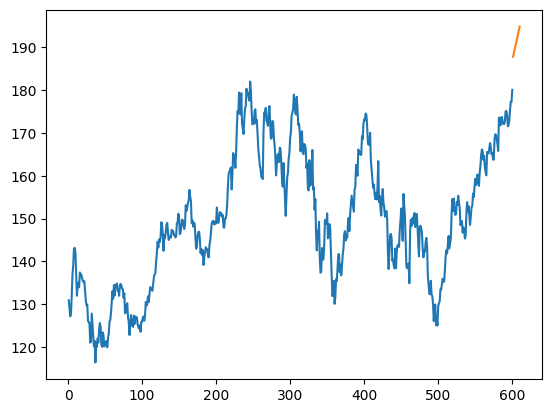

In [130]:
plt.plot(day_new,scaler.inverse_transform(df1[5039:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

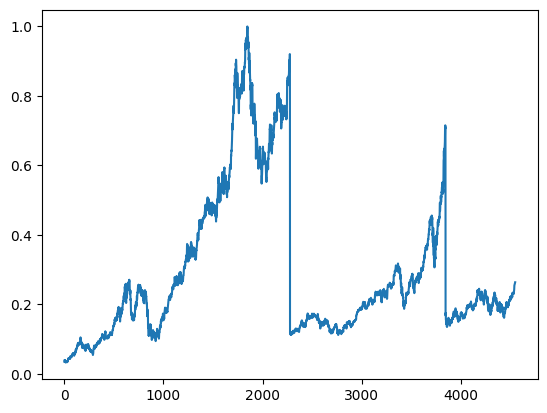

In [132]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1100:])

In [133]:
df3=scaler.inverse_transform(df3).tolist()

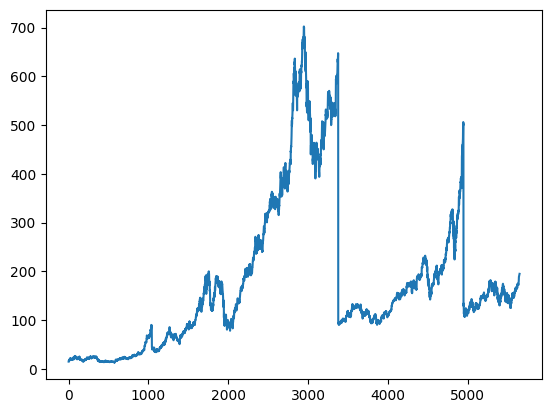

In [134]:
plt.plot(df3)